<a href="https://colab.research.google.com/github/AmeerTechsoft/Data-science-project/blob/main/Sentiment_analysis_of_amazon_products_(women_clothing).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Importing the necessary modules

!pip install nltk
!pip install textblob
!pip install wordcloud
!pip install xgboost

from warnings import filterwarnings
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from PIL import Image
from nltk.corpus import stopwords
from nltk.sentiment import SentimentIntensityAnalyzer
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from xgboost import XGBClassifier
from sklearn.model_selection import cross_val_score, GridSearchCV, cross_validate, train_test_split
from sklearn.preprocessing import LabelEncoder
from textblob import Word, TextBlob
from nltk.tokenize import word_tokenize
from wordcloud import WordCloud
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
import re
import string
from nltk.stem import WordNetLemmatizer
import nltk
nltk.download("stopwords")
nltk.download("wordnet")
nltk.download("vader_lexicon")
nltk.download('punkt')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package vader_lexicon to /root/nltk_data...
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [ ]:
STOPWORDS = stopwords.words('english')

In [ ]:
df = pd.read_csv('./drive/MyDrive/clothings/Womens Clothing E-Commerce Reviews.csv') # Reading the dataset

In [ ]:
df.head()

,Unnamed: 0,Clothing ID,Age,Title,Review Text,Rating,Recommended IND,Positive Feedback Count,Division Name,Department Name,Class Name
0,0,767,33,NaN,Absolutely wonderful - silky and sexy and comf...,4,1,0,Initmates,Intimate,Intimates
1,1,1080,34,NaN,Love this dress! it's sooo pretty. i happene...,5,1,4,General,Dresses,Dresses
2,2,1077,60,Some major design flaws,I had such high hopes for this dress and reall...,3,0,0,General,Dresses,Dresses
3,3,1049,50,My favorite buy!,"I love, love, love this jumpsuit. it's fun, fl...",5,1,0,General Petite,Bottoms,Pants
4,4,847,47,Flattering shirt,This shirt is very flattering to all due to th...,5,1,6,General,Tops,Blouses


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 19662 entries, 2 to 23485
Data columns (total 10 columns):
 #   Column                   Non-Null Count  Dtype 
---  ------                   --------------  ----- 
 0   Clothing ID              19662 non-null  int64 
 1   Age                      19662 non-null  int64 
 2   Title                    19662 non-null  object
 3   Review Text              19662 non-null  object
 4   Rating                   19662 non-null  int64 
 5   Recommended IND          19662 non-null  int64 
 6   Positive Feedback Count  19662 non-null  int64 
 7   Division Name            19662 non-null  object
 8   Department Name          19662 non-null  object
 9   Class Name               19662 non-null  object
dtypes: int64(5), object(5)
memory usage: 1.7+ MB


In [ ]:
df.isna().sum()

Unnamed: 0                    0
Clothing ID                   0
Age                           0
Title                      3810
Review Text                 845
Rating                        0
Recommended IND               0
Positive Feedback Count       0
Division Name                14
Department Name              14
Class Name                   14
dtype: int64

In [ ]:
df.dropna(axis=0, inplace=True)

In [ ]:
df.drop(columns=['Unnamed: 0'], inplace=True)

In [ ]:
df.duplicated().sum()

0

In [ ]:
df.drop_duplicates(inplace=True)

##**EDA**

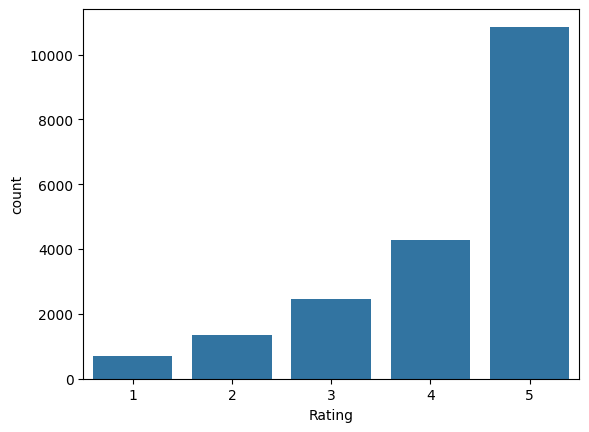

In [ ]:
# prompt: plot he rating cout

sns.countplot(x='Rating', data=df)
plt.show()


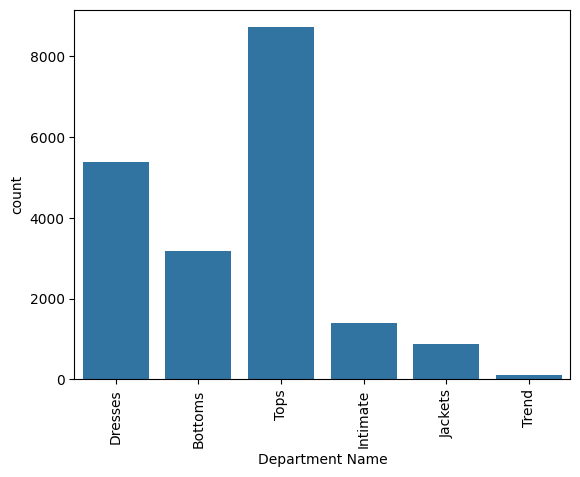

In [ ]:
sns.countplot(x='Department Name', data=df)
plt.xticks(rotation=90)
plt.show()


In [ ]:
df["Recommended IND"].value_counts()

Recommended IND
1    16087
0     3575
Name: count, dtype: int64

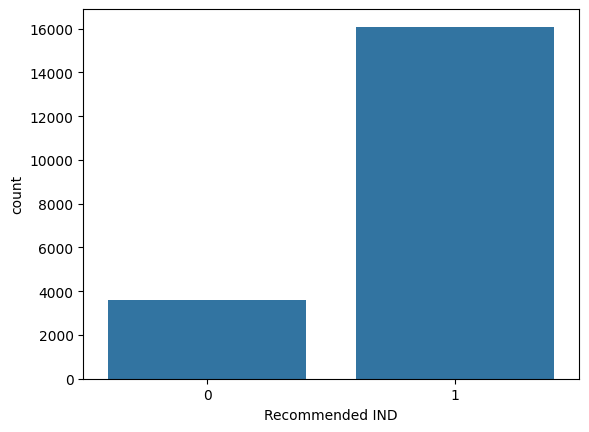

In [ ]:
sns.countplot(x='Recommended IND', data=df)
plt.show()


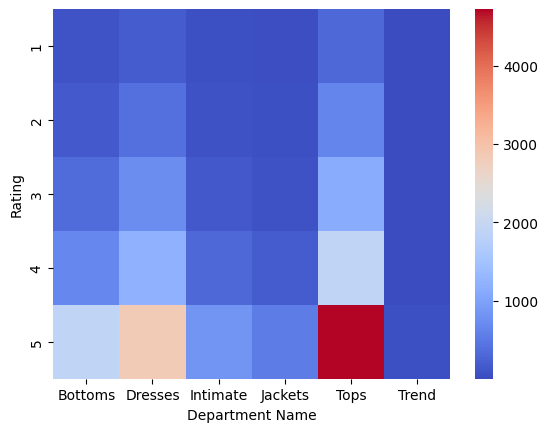

In [ ]:
# Further exploring the relationship between rating and department name
df_grouped = df.groupby(['Rating', 'Department Name'])['Rating'].count().unstack()
sns.heatmap(df_grouped, cmap='coolwarm')
plt.show()

In [ ]:
# prompt: tokenize the review

def tokenize_review(text):
  text = re.sub(r'http\S+', ' ', text)  # Remove URLs
  text = re.sub(r'[^a-zA-Z\s]', '', text)  # Remove special characters and punctuation
  tokens = word_tokenize(text.lower())  # Tokenize the text
  stop_words = set(stopwords.words('english'))  # Create a set of stop words
  tokens = [token for token in tokens if token not in stop_words]  # Remove stop words
  lemmatizer = WordNetLemmatizer()  # Initialize the lemmatizer
  tokens = [lemmatizer.lemmatize(token) for token in tokens]  # Lemmatize the tokens
  return tokens

df['Cleaned_Review_Text'] = df['Review Text'].apply(tokenize_review)


In [ ]:
df['Cleaned_Review_Text']

2        [high, hope, dress, really, wanted, work, init...
3        [love, love, love, jumpsuit, fun, flirty, fabu...
4        [shirt, flattering, due, adjustable, front, ti...
5        [love, tracy, reese, dress, one, petite, foot,...
6        [aded, basket, hte, last, mintue, see, would, ...
                               ...                        
23481    [happy, snag, dress, great, price, easy, slip,...
23482    [reminds, maternity, clothes, soft, stretchy, ...
23483    [fit, well, top, see, never, would, worked, im...
23484    [bought, dress, wedding, summer, cute, unfortu...
23485    [dress, lovely, platinum, feminine, fit, perfe...
Name: Cleaned_Review_Text, Length: 19662, dtype: object

In [ ]:
# rejoin the tokenized cleaned review text

df['Cleaned_Review_Text'] = [' '.join(tokens) for tokens in df['Cleaned_Review_Text']]


In [ ]:
df['Cleaned_Review_Text']

2        high hope dress really wanted work initially o...
3        love love love jumpsuit fun flirty fabulous ev...
4        shirt flattering due adjustable front tie perf...
5        love tracy reese dress one petite foot tall us...
6        aded basket hte last mintue see would look lik...
                               ...                        
23481    happy snag dress great price easy slip flatter...
23482    reminds maternity clothes soft stretchy shiny ...
23483    fit well top see never would worked im glad ab...
23484    bought dress wedding summer cute unfortunately...
23485    dress lovely platinum feminine fit perfectly e...
Name: Cleaned_Review_Text, Length: 19662, dtype: object

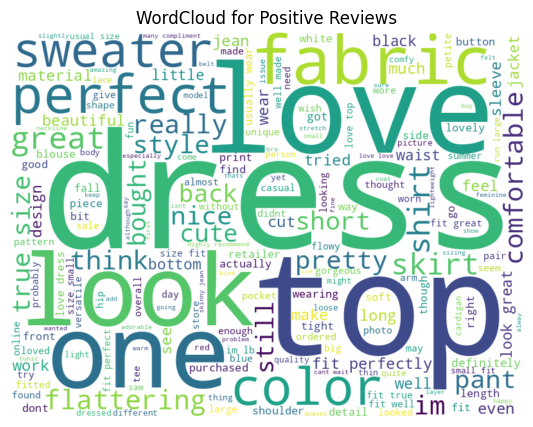

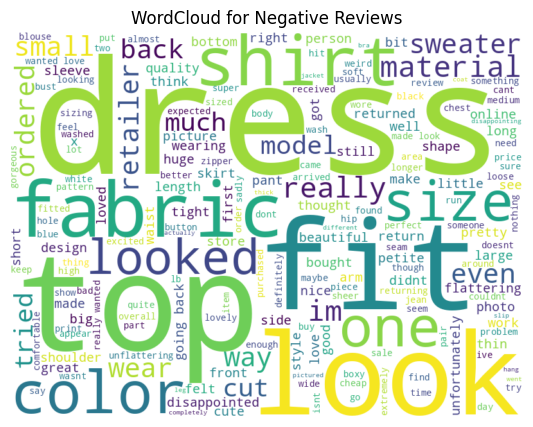

In [ ]:
# Create a word cloud for positive reviews
positive_reviews = df[df['Rating'] >= 4]['Cleaned_Review_Text']
positive_words = ' '.join(positive_reviews)
wordcloud = WordCloud(width=800, height=600, background_color='white').generate(positive_words)
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('WordCloud for Positive Reviews')
plt.show()

# Create a word cloud for negative reviews
negative_reviews = df[df['Rating'] <= 2]['Cleaned_Review_Text']
negative_words = ' '.join(negative_reviews)
wordcloud = WordCloud(width=800, height=600, background_color='white').generate(negative_words)
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('WordCloud for Negative Reviews')
plt.show()


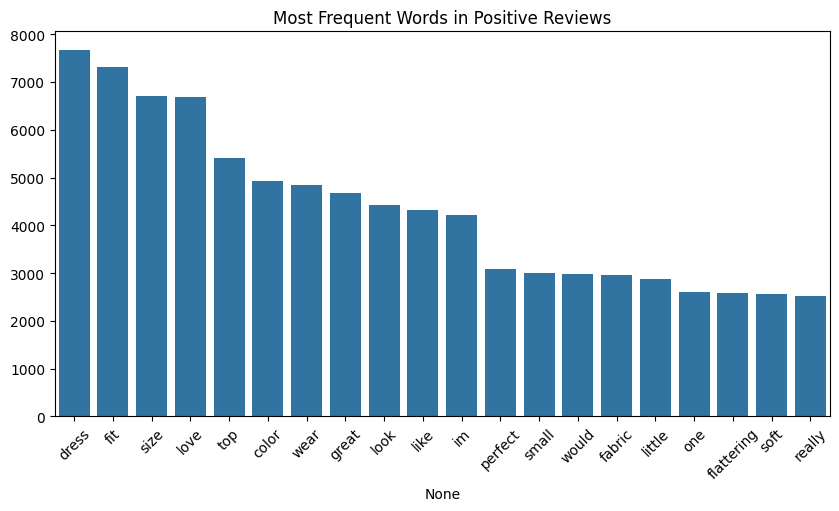

In [ ]:
# Identifying the most frequent words in positive reviews
positive_reviews = df[df['Rating'] >= 4]['Cleaned_Review_Text']

positive_words = ' '.join(positive_reviews).split()

positive_word_freq = pd.Series(positive_words).value_counts().head(20)

# Visualizing the most frequent Positive words
plt.figure(figsize=(10, 5))
sns.barplot(x=positive_word_freq.index, y=positive_word_freq.values)
plt.title('Most Frequent Words in Positive Reviews')
plt.tick_params(axis='x', rotation=45)
plt.show()

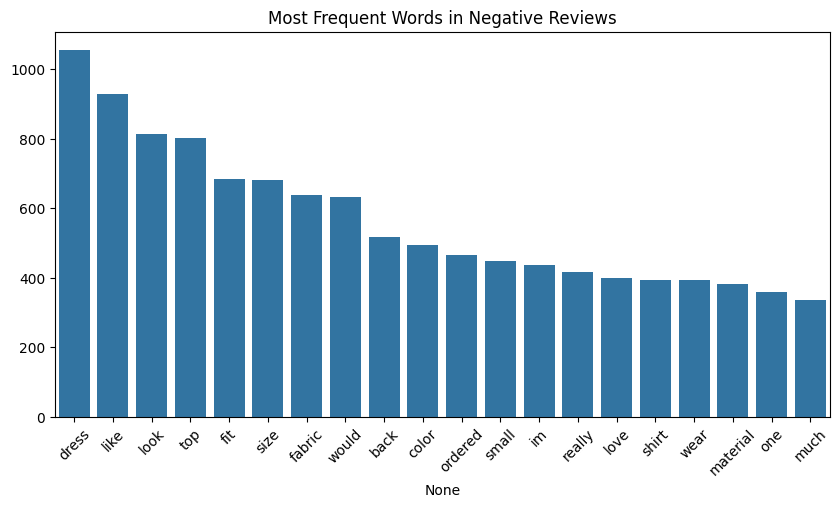

In [ ]:
# Identifying the most frequent words in negative reviews
negative_reviews = df[df['Rating'] <= 2]['Cleaned_Review_Text']

negative_words = ' '.join(negative_reviews).split()

negative_word_freq = pd.Series(negative_words).value_counts().head(20)

# Visualizing the most frequent Negative words
plt.figure(figsize=(10, 5))
sns.barplot(x=negative_word_freq.index, y=negative_word_freq.values)
plt.title('Most Frequent Words in Negative Reviews')
plt.tick_params(axis='x', rotation=45)
plt.show()

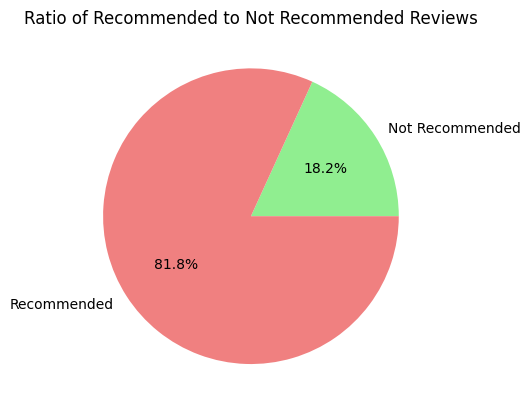

In [ ]:
# Create a pie chart of the recommended vs. not recommended reviews
labels = ['Not Recommended', 'Recommended']
sizes = [df['Recommended IND'].value_counts()[0], df['Recommended IND'].value_counts()[1]]
colors = ['lightgreen', 'lightcoral']

plt.pie(sizes, labels=labels, colors=colors, autopct='%1.1f%%')
plt.title('Ratio of Recommended to Not Recommended Reviews')
plt.show()

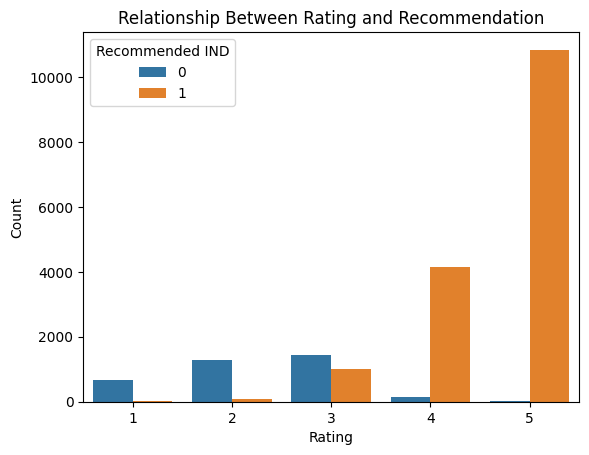

In [ ]:
# the relationship between rating and recommendation
sns.countplot(x='Rating', hue='Recommended IND', data=df)
plt.xlabel('Rating')
plt.ylabel('Count')
plt.title('Relationship Between Rating and Recommendation')
plt.show()


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 19662 entries, 2 to 23485
Data columns (total 13 columns):
 #   Column                   Non-Null Count  Dtype   
---  ------                   --------------  -----   
 0   Clothing ID              19662 non-null  int64   
 1   Age                      19662 non-null  int64   
 2   Title                    19662 non-null  object  
 3   Review Text              19662 non-null  object  
 4   Rating                   19662 non-null  int64   
 5   Recommended IND          19662 non-null  int64   
 6   Positive Feedback Count  19662 non-null  int64   
 7   Division Name            19662 non-null  object  
 8   Department Name          19662 non-null  object  
 9   Class Name               19662 non-null  object  
 10  Cleaned_Review_Text      19662 non-null  object  
 11  Review_Length            19662 non-null  int64   
 12  Age_Group                19658 non-null  category
dtypes: category(1), int64(6), object(6)
memory usage: 2.0+ MB


In [ ]:
# create age group

def create_age_group(age):
  if age < 25:
    return '18-24'
  elif age < 35:
    return '25-34'
  elif age < 45:
    return '35-44'
  elif age < 55:
    return '45-54'
  elif age < 65:
    return '55-64'
  else:
    return '65+'

df['Age_Group'] = df['Age'].apply(create_age_group)
df.head()

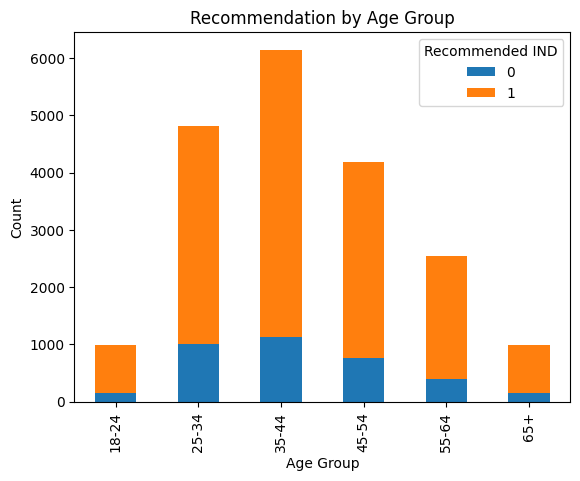

In [ ]:
# Group the data by age and recommendation
grouped_data = df.groupby(['Age_Group', 'Recommended IND'])['Recommended IND'].count().unstack()

# Plot the grouped data as a bar chart
grouped_data.plot(kind='bar', stacked=True)
plt.title('Recommendation by Age Group')
plt.xlabel('Age Group')
plt.ylabel('Count')
plt.show()


## **Model Training**

In [ ]:
# using the minority count to re sample the data

df_majority = df[df['Recommended IND'] == 0]
df_minority = df[df['Recommended IND'] == 1]

df_minority_upsampled = df_minority.sample(len(df_majority), replace=True)

df_balanced = pd.concat([df_majority, df_minority_upsampled])

df_balanced['Recommended IND'].value_counts()


Recommended IND
0    3575
1    3575
Name: count, dtype: int64

In [ ]:
# split the data

X = df_balanced['Cleaned_Review_Text']
y = df_balanced['Recommended IND']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [ ]:
print("X_train shape:", X_train.shape)
print("X_test shape:", X_test.shape)
print("y_train shape:", y_train.shape)
print("y_test shape:", y_test.shape)

X_train shape: (5720,)
X_test shape: (1430,)
y_train shape: (5720,)
y_test shape: (1430,)


In [ ]:
# prompt: applying count and tfifd vectorizers

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

# CountVectorizer
count_vect = CountVectorizer(stop_words='english')
X_train_count = count_vect.fit_transform(X_train)
X_test_count = count_vect.transform(X_test)

# TF-IDF Vectorizer
tfidf_vect = TfidfVectorizer(stop_words='english')
X_train_tfidf = tfidf_vect.fit_transform(X_train)
X_test_tfidf = tfidf_vect.transform(X_test)


In [ ]:
# CountVectorizer
count_vect = CountVectorizer(stop_words='english')
X_train_count = count_vect.fit_transform(X_train)
X_test_count = count_vect.transform(X_test)

# TF-IDF Vectorizer
tfidf_vect = TfidfVectorizer(stop_words='english')
X_train_tfidf = tfidf_vect.fit_transform(X_train)
X_test_tfidf = tfidf_vect.transform(X_test)

In [ ]:
#Define Hyperparameter grids
param_grid_logreg = {'C': [0.1, 1, 10], 'penalty': ['l1', 'l2']}
param_grid_rf = {'n_estimators': [10, 50, 100], 'max_depth': [None, 5, 10]}
param_grid_svm = {'C': [0.1, 1, 10], 'gamma': [1, 0.1, 0.01], 'kernel': ['rbf', 'linear']}
param_grid_nb = {'alpha': [0.1, 1, 10]}
param_grid_xgb = {'learning_rate': [0.1, 0.01], 'max_depth': [None, 5, 10], 'n_estimators': [100, 200]}

In [ ]:
# TF-IDF Vectorizer
logreg_tfidf = LogisticRegression(max_iter=1000000)
grid_search_logreg_tfidf = GridSearchCV(logreg_tfidf, param_grid_logreg, cv=5)
grid_search_logreg_tfidf.fit(X_train_tfidf, y_train)

rf_tfidf = RandomForestClassifier()
grid_search_rf_tfidf = GridSearchCV(rf_tfidf, param_grid_rf, cv=5)
grid_search_rf_tfidf.fit(X_train_tfidf, y_train)

svm_tfidf = SVC()
grid_search_svm_tfidf = GridSearchCV(svm_tfidf, param_grid_svm, cv=5)
grid_search_svm_tfidf.fit(X_train_tfidf, y_train)

nb_tfidf = MultinomialNB()
grid_search_nb_tfidf = GridSearchCV(nb_tfidf, param_grid_nb, cv=5)
grid_search_nb_tfidf.fit(X_train_tfidf, y_train)

xgb_tfidf = XGBClassifier()
grid_search_xgb_tfidf = GridSearchCV(xgb_tfidf, param_grid_xgb, cv=5)
grid_search_xgb_tfidf.fit(X_train_tfidf, y_train)


# Count Vectorizer
logreg_count = LogisticRegression(max_iter=1000000)
grid_search_logreg_count = GridSearchCV(logreg_count, param_grid_logreg, cv=5)
grid_search_logreg_count.fit(X_train_count, y_train)

rf_count = RandomForestClassifier()
grid_search_rf_count = GridSearchCV(rf_count, param_grid_rf, cv=5)
grid_search_rf_count.fit(X_train_count, y_train)

svm_count = SVC()
grid_search_svm_count = GridSearchCV(svm_count, param_grid_svm, cv=5)
grid_search_svm_count.fit(X_train_count, y_train)

nb_count = MultinomialNB()
grid_search_nb_count = GridSearchCV(nb_count, param_grid_nb, cv=5)
grid_search_nb_count.fit(X_train_count, y_train)

xgb_count = XGBClassifier()
grid_search_xgb_count = GridSearchCV(xgb_count, param_grid_xgb, cv=5)
grid_search_xgb_count.fit(X_train_count, y_train)


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:378: FitFailedWarning: 
15 fits failed out of a total of 30.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
15 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py", line 1162, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py", line 54, in _check_solver
    raise ValueError(
ValueError: Solve

GridSearchCV(cv=5,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None, device=None,
                                     early_stopping_rounds=None,
                                     enable_categorical=False, eval_metric=None,
                                     feature_types=None, gamma=None,
                                     grow_policy=None, importance_type=None,
                                     interaction_constraints=None,
                                     learning_rate=None,...in=None,
                                     max_cat_threshold=None,
                                     max_cat_to_onehot=None,
                                     max_delta_step=None, max_depth=None,
                                     max_leaves=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     multi_strategy=None, n_estimators=None,
                                     n_jobs=None, num_parallel_tree=None,
                                     random_state=None, ...),
             param_grid={'learning_rate': [0.1, 0.01],
                         'max_depth': [None, 5, 10],
                         'n_estimators': [100, 200]})

In [ ]:
# TF-IDF Vectorizer
print(f"TF-IDF Vectorizer Results")
print(f"Logistic Regression: {grid_search_logreg_tfidf.best_params_} {grid_search_logreg_tfidf.best_score_}")
print(f"Random Forest: {grid_search_rf_tfidf.best_params_ } {grid_search_rf_tfidf.best_score_}")
print(f"SVM: {grid_search_svm_tfidf.best_params_} {grid_search_svm_tfidf.best_score_}")
print(f"Naive Bayes: {grid_search_nb_tfidf.best_params_} {grid_search_nb_tfidf.best_score_}")
print(f"XGBoost: {grid_search_xgb_tfidf.best_params_} {grid_search_xgb_tfidf.best_score_}")



# Count Vectorizer
print(f"\nCount Vectorizer Results")
print(f"Logistic Regression: {grid_search_logreg_count.best_params_} {grid_search_logreg_count.best_score_}")
print(f"Random Forest: {grid_search_rf_count.best_params_ } {grid_search_rf_count.best_score_}")
print(f"SVM: {grid_search_svm_count.best_params_} {grid_search_svm_count.best_score_}")
print(f"Naive Bayes: {grid_search_nb_count.best_params_} {grid_search_nb_count.best_score_}")
print(f"XGBoost: {grid_search_xgb_count.best_params_} {grid_search_xgb_count.best_score_}")


TF-IDF Vectorizer Results
Logistic Regression: {'C': 1, 'penalty': 'l2'} 0.8426573426573427
Random Forest: {'max_depth': None, 'n_estimators': 100} 0.8382867132867131
SVM: {'C': 1, 'gamma': 1, 'kernel': 'rbf'} 0.8538461538461538
Naive Bayes: {'alpha': 1} 0.8368881118881119
XGBoost: {'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 200} 0.8346153846153845

Count Vectorizer Results
Logistic Regression: {'C': 0.1, 'penalty': 'l2'} 0.8347902097902098
Random Forest: {'max_depth': None, 'n_estimators': 100} 0.841958041958042
SVM: {'C': 10, 'gamma': 0.01, 'kernel': 'rbf'} 0.8452797202797203
Naive Bayes: {'alpha': 1} 0.8423076923076923
XGBoost: {'learning_rate': 0.1, 'max_depth': 10, 'n_estimators': 200} 0.8377622377622377


In [ ]:
# TF-IDF Vectorizer
best_logreg_tfidf = LogisticRegression(**grid_search_logreg_tfidf.best_params_, max_iter=1000000)
best_rf_tfidf = RandomForestClassifier(**grid_search_rf_tfidf.best_params_)
best_svm_tfidf = SVC(**grid_search_svm_tfidf.best_params_, probability=True)
best_nb_tfidf = MultinomialNB(**grid_search_nb_tfidf.best_params_)
best_xgb_tfidf = XGBClassifier(**grid_search_xgb_tfidf.best_params_)

# Count Vectorizer
best_logreg_count = LogisticRegression(**grid_search_logreg_count.best_params_, max_iter=1000000)
best_rf_count = RandomForestClassifier(**grid_search_rf_count.best_params_)
best_svm_count = SVC(**grid_search_svm_count.best_params_, probability=True)
best_nb_count = MultinomialNB(**grid_search_nb_count.best_params_)
best_xgb_count = XGBClassifier(**grid_search_xgb_count.best_params_)

# Fit the best models
best_logreg_tfidf.fit(X_train_tfidf, y_train)
best_rf_tfidf.fit(X_train_tfidf, y_train)
best_svm_tfidf.fit(X_train_tfidf, y_train)
best_nb_tfidf.fit(X_train_tfidf, y_train)
best_xgb_tfidf.fit(X_train_tfidf, y_train)

best_logreg_count.fit(X_train_count, y_train)
best_rf_count.fit(X_train_count, y_train)
best_svm_count.fit(X_train_count, y_train)
best_nb_count.fit(X_train_count, y_train)
best_xgb_count.fit(X_train_count, y_train)


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.1, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=10, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=200, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)

In [ ]:
best_svm_tfidf.fit(X_train_tfidf, y_train)
best_svm_count.fit(X_train_count, y_train)

SVC(C=10, gamma=0.01, probability=True)

In [ ]:
from sklearn.metrics import accuracy_score

In [ ]:
# TF-IDF Vectorizer
logreg_tfidf_accuracy = best_logreg_tfidf.score(X_test_tfidf, y_test)
rf_tfidf_accuracy = best_rf_tfidf.score(X_test_tfidf, y_test)
svm_tfidf_accuracy = best_svm_tfidf.score(X_test_tfidf, y_test)
nb_tfidf_accuracy = best_nb_tfidf.score(X_test_tfidf, y_test)
xgb_tfidf_accuracy = best_xgb_tfidf.score(X_test_tfidf, y_test)

# Count Vectorizer
logreg_count_accuracy = best_logreg_count.score(X_test_count, y_test)
rf_count_accuracy = best_rf_count.score(X_test_count, y_test)
svm_count_accuracy = best_svm_count.score(X_test_count, y_test)
nb_count_accuracy = best_nb_count.score(X_test_count, y_test)
xgb_count_accuracy = best_xgb_count.score(X_test_count, y_test)

# Print the accuracy scores
print("TF-IDF Vectorizer Accuracy:")
print(f"Logistic Regression: {logreg_tfidf_accuracy:.3f}")
print(f"Random Forest: {rf_tfidf_accuracy:.3f}")
print(f"SVM: {svm_tfidf_accuracy:.3f}")
print(f"Naive Bayes: {nb_tfidf_accuracy:.3f}")
print(f"XGBoost: {xgb_tfidf_accuracy:.3f}")

print("\nCount Vectorizer Accuracy:")
print(f"Logistic Regression: {logreg_count_accuracy:.3f}")
print(f"Random Forest: {rf_count_accuracy:.3f}")
print(f"SVM: {svm_count_accuracy:.3f}")
print(f"Naive Bayes: {nb_count_accuracy:.3f}")
print(f"XGBoost: {xgb_count_accuracy:.3f}")


TF-IDF Vectorizer Accuracy:
Logistic Regression: 0.862
Random Forest: 0.848
SVM: 0.864
Naive Bayes: 0.858
XGBoost: 0.830

Count Vectorizer Accuracy:
Logistic Regression: 0.852
Random Forest: 0.852
SVM: 0.850
Naive Bayes: 0.856
XGBoost: 0.825


In [ ]:
# Calculate the AUROC scores for each model with TF-IDF Vectorizer
logreg_tfidf_aucroc = roc_auc_score(y_test, best_logreg_tfidf.predict_proba(X_test_tfidf)[:, 1])
rf_tfidf_aucroc = roc_auc_score(y_test, best_rf_tfidf.predict_proba(X_test_tfidf)[:, 1])
svm_tfidf_aucroc = roc_auc_score(y_test, best_svm_tfidf.predict_proba(X_test_tfidf)[:, 1])
nb_tfidf_aucroc = roc_auc_score(y_test, best_nb_tfidf.predict_proba(X_test_tfidf)[:, 1])
xgb_tfidf_aucroc = roc_auc_score(y_test, best_xgb_tfidf.predict_proba(X_test_tfidf)[:, 1])

# Calculate the AUROC scores for each model with Count Vectorizer
logreg_count_aucroc = roc_auc_score(y_test, best_logreg_count.predict_proba(X_test_count)[:, 1])
rf_count_aucroc = roc_auc_score(y_test, best_rf_count.predict_proba(X_test_count)[:, 1])
svm_count_aucroc = roc_auc_score(y_test, best_svm_count.predict_proba(X_test_count)[:, 1])
nb_count_aucroc = roc_auc_score(y_test, best_nb_count.predict_proba(X_test_count)[:, 1])
xgb_count_aucroc = roc_auc_score(y_test, best_xgb_count.predict_proba(X_test_count)[:, 1])

In [ ]:
# Print the AUC scores
print("TF-IDF Vectorizer AUC Scores:")
print(f"Logistic Regression: {logreg_tfidf_aucroc:.3f}")
print(f"Random Forest: {rf_tfidf_aucroc:.3f}")
print(f"SVM: {svm_tfidf_aucroc:.3f}")
print(f"Naive Bayes: {nb_tfidf_aucroc:.3f}")
print(f"XGBoost: {xgb_tfidf_aucroc:.3f}")

print("\nCount Vectorizer AUC Scores:")
print(f"Logistic Regression: {logreg_count_aucroc:.3f}")
print(f"Random Forest: {rf_count_aucroc:.3f}")
print(f"SVM: {svm_count_aucroc:.3f}")
print(f"Naive Bayes: {nb_count_aucroc:.3f}")
print(f"XGBoost: {xgb_count_aucroc:.3f}")

TF-IDF Vectorizer AUC Scores:
Logistic Regression: 0.916
Random Forest: 0.916
SVM: 0.928
Naive Bayes: 0.924
XGBoost: 0.903

Count Vectorizer AUC Scores:
Logistic Regression: 0.908
Random Forest: 0.915
SVM: 0.914
Naive Bayes: 0.922
XGBoost: 0.912


In [ ]:
# Print the classification report for each model with TF-IDF Vectorizer
print("TF-IDF Vectorizer Classification Reports:")
print("Logistic Regression:")
print(classification_report(y_test, best_logreg_tfidf.predict(X_test_tfidf)))
print("Random Forest:")
print(classification_report(y_test, best_rf_tfidf.predict(X_test_tfidf)))
print("SVM:")
print(classification_report(y_test, best_svm_tfidf.predict(X_test_tfidf)))
print("Naive Bayes:")
print(classification_report(y_test, best_nb_tfidf.predict(X_test_tfidf)))
print("XGBoost:")
print(classification_report(y_test, best_xgb_tfidf.predict(X_test_tfidf)))

# Print the classification report for each model with Count Vectorizer
print("\nCount Vectorizer Classification Reports:")
print("Logistic Regression:")
print(classification_report(y_test, best_logreg_count.predict(X_test_count)))
print("Random Forest:")
print(classification_report(y_test, best_rf_count.predict(X_test_count)))
print("SVM:")
print(classification_report(y_test, best_svm_count.predict(X_test_count)))
print("Naive Bayes:")
print(classification_report(y_test, best_nb_count.predict(X_test_count)))
print("XGBoost:")
print(classification_report(y_test, best_xgb_count.predict(X_test_count)))


TF-IDF Vectorizer Classification Reports:
Logistic Regression:
              precision    recall  f1-score   support

           0       0.87      0.85      0.86       722
           1       0.85      0.88      0.86       708

    accuracy                           0.86      1430
   macro avg       0.86      0.86      0.86      1430
weighted avg       0.86      0.86      0.86      1430

Random Forest:
              precision    recall  f1-score   support

           0       0.85      0.84      0.85       722
           1       0.84      0.85      0.85       708

    accuracy                           0.85      1430
   macro avg       0.85      0.85      0.85      1430
weighted avg       0.85      0.85      0.85      1430

SVM:
              precision    recall  f1-score   support

           0       0.87      0.86      0.86       722
           1       0.86      0.87      0.86       708

    accuracy                           0.86      1430
   macro avg       0.86      0.86      0.86  

In [ ]:
import pickle

# Save the best TF-IDF Logistic Regression model
with open('./drive/MyDrive/Models/best_logreg_tfidf.pkl', 'wb') as file:
    pickle.dump(best_logreg_tfidf, file)

# Save the best TF-IDF Random Forest model
with open('./drive/MyDrive/Models/best_rf_tfidf.pkl', 'wb') as file:
    pickle.dump(best_rf_tfidf, file)

# Save the best TF-IDF SVM model
with open('./drive/MyDrive/Models/best_svm_tfidf.pkl', 'wb') as file:
    pickle.dump(best_svm_tfidf, file)

# Save the best TF-IDF Naive Bayes model
with open('./drive/MyDrive/Models/best_nb_tfidf.pkl', 'wb') as file:
    pickle.dump(best_nb_tfidf, file)

# Save the best TF-IDF XGBoost model
with open('./drive/MyDrive/Models/best_xgb_tfidf.pkl', 'wb') as file:
    pickle.dump(best_xgb_tfidf, file)

# Save the best Count Vectorizer Logistic Regression model
with open('./drive/MyDrive/Models/best_logreg_count.pkl', 'wb') as file:
    pickle.dump(best_logreg_count, file)

# Save the best Count Vectorizer Random Forest model
with open('./drive/MyDrive/Models/best_rf_count.pkl', 'wb') as file:
    pickle.dump(best_rf_count, file)

# Save the best Count Vectorizer SVM model
with open('./drive/MyDrive/Models/best_svm_count.pkl', 'wb') as file:
    pickle.dump(best_svm_count, file)

# Save the best Count Vectorizer Naive Bayes model
with open('./drive/MyDrive/Models/best_nb_count.pkl', 'wb') as file:
    pickle.dump(best_nb_count, file)

# Save the best Count Vectorizer XGBoost model
with open('./drive/MyDrive/Models/best_xgb_count.pkl', 'wb') as file:
    pickle.dump(best_xgb_count, file)

# Save the TF-IDF Vectorizer
with open('./drive/MyDrive/Models/tfidf_vect.pkl', 'wb') as file:
    pickle.dump(tfidf_vect, file)

# Save the Count Vectorizer
with open('./drive/MyDrive/Models/count_vect.pkl', 'wb') as file:
    pickle.dump(count_vect, file)

